In [183]:
import torch
from __future__ import absolute_import, division, print_function
import torch
from torch.distributions import constraints
from torch.nn import Parameter
import pyro
from pyro.contrib.gp.util import Parameterized
import pyro.distributions as dist
import pyro.infer as infer
import pyro.optim as optim
from pyro.params import param_with_module_name
import pyro.contrib.gp as gp
import pyro.distributions as dist
import matplotlib.pyplot as plt
pyro.clear_param_store()
import tensorflow as tf
import numpy as np 
import pandas as pd
import numpy
import math
import cProfile
import time
import GPy
import numpy as np
from matplotlib import pyplot as plt

import statsmodels.api as sm
import sympy as sp
#import pymc
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from scipy.special import gamma
from GPy.core.parameterization.variational import NormalPosterior, NormalPrior

from sympy.interactive import printing
import pyro.contrib.gp.models.vsgp as vsgp
from GPy.util.linalg import pdinv
from pyro.infer.mcmc.hmc import HMC
from pyro.infer.mcmc import MCMC
from matplotlib import pyplot
pyro.clear_param_store()
import time
torch.manual_seed(12)
pyro.set_rng_seed(101)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
import numpy as np 


In [184]:
data = pods.datasets.oil_100()

In [186]:
Y=data['X']
Y_t= torch.Tensor(Y.T)
#N = Y.shape[0]
#sample_mean = np.mean(Y[:N,:])
#sample_std = np.std(Y[:N,:])
#sample_norm = (Y[:N,:] - sample_mean)/sample_std # normalisation
#Y_t = torch.Tensor(sample_norm.T)

In [152]:
def initialize_latent(input_dim, Y):
    Xr = np.asfortranarray(np.random.normal(0, 1, (Y.shape[0], input_dim)))
    p = GPy.util.pca.PCA(Y)
    PC = p.project(Y, min(input_dim, Y.shape[1]))
    Xr[:PC.shape[0], :PC.shape[1]] = PC
    var = .1*p.fracs[:input_dim]
    Xr -= Xr.mean(0)
    Xr /= Xr.std(0)
    return Xr, var/var.max()

In [194]:
Xr, fracs = initialize_latent(5, Y)
fracs = torch.tensor(1./fracs).float()
X_loc = torch.zeros(Y.shape[0], 5)
kernel = gp.kernels.RBF(input_dim=5, lengthscale=fracs,variance=torch.ones(1))
Xu = torch.zeros(20, 5)
gpmodel = gp.models.SparseGPRegression(X_loc, Y_t, kernel, Xu, noise=torch.tensor(1.),approx='DTC')
gplvm = gp.models.GPLVM(gpmodel)

In [195]:
gplvm.base_model.approx

'DTC'

CPU+SystemTime:207.0625 seconds
Code Run Time:207.4037947654724 seconds


Text(0.5,1,'Convergence of SVI')

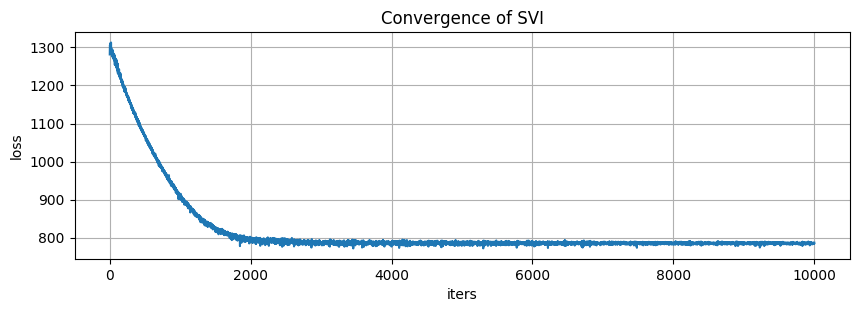

In [189]:
i=list(range(1,10001))
st = time.process_time()
st2 = time.time()
losses = gplvm.optimize(num_steps=10000)  # doctest: +SKIP
end =  time.process_time()
end2 = time.time()
print(str('CPU+SystemTime:')+str(end-st)+' '+str('seconds'))
print(str('Code Run Time:')+str(end2-st2)+' '+str('seconds'))
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(i,losses)
pyplot.xlabel('iters')
pyplot.ylabel('loss')
pyplot.grid()
pyplot.title('Convergence of SVI')

Text(0.5,1,'Convergence of SVI')

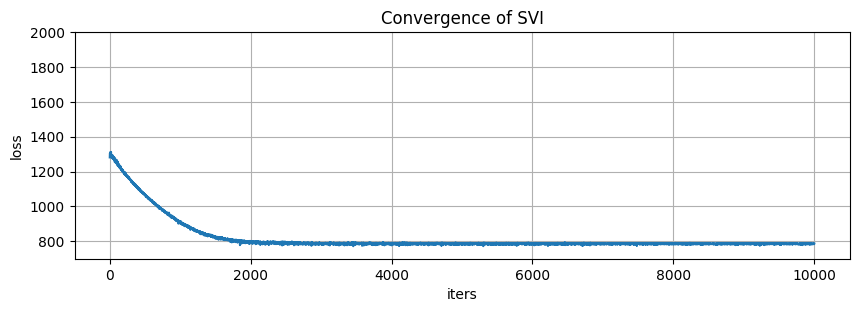

In [192]:
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(i,losses)
pyplot.xlabel('iters')
pyplot.ylabel('loss')
pyplot.grid()
pyplot.ylim([700,2000])
pyplot.title('Convergence of SVI')

In [196]:
X = gplvm.get_param("X_loc")
X_var = gplvm.get_param("X_scale_tril")
Kfu = gplvm.base_model.kernel(X, gplvm.base_model.Xu).detach().numpy()
Kuu = gplvm.base_model.kernel(gplvm.base_model.Xu, gplvm.base_model.Xu).detach().numpy()
Kuf = Kfu.T
print('Kfu shape'+str(Kfu.shape))
print('Kuu shape'+str(Kuu.shape))
print('Kuf shape'+str(Kuf.shape))
noise = gplvm.base_model.get_param('noise').detach().numpy()
K = np.dot(np.dot(Kfu,pdinv(Kuu)[0]),Kuf)  + np.eye(X.shape[0])*(1/noise)

Kfu shape(100, 20)
Kuu shape(20, 20)
Kuf shape(20, 100)


 /home/aneeqr/.local/lib/python3.6/site-packages/matplotlib/__init__.py:1867: MatplotlibDeprecationWarning:The *left* kwarg to `bar` is deprecated use *x* instead. Support for *left* will be removed in Matplotlib 3.0
 /home/aneeqr/.local/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


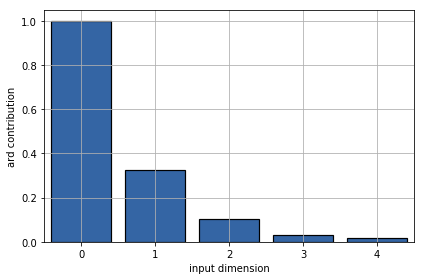

In [197]:
active = gplvm.base_model.kernel.active_dims
input_dim = gplvm.base_model.kernel.input_dim
Var = gplvm.base_model.kernel.get_param('variance').detach().numpy()
Len = gplvm.base_model.kernel.get_param('lengthscale').detach().numpy()
Co = GPy.kern.RBF(ARD=True,active_dims=active,input_dim=input_dim,lengthscale=Len,variance=Var)
Co.K = K
Co.plot_ARD()
plt.grid()

Neearest neighbourboost size k =1 Continuity:0.5182653061224489
Neearest neighbourboost size k =5 Continuity:0.5161739130434781
Neearest neighbourboost size k =10 Continuity:0.5283786982248521
Neearest neighbourboost size k =15 Continuity:0.5448051948051948
Neearest neighbourboost size k =20 Continuity:0.5619568345323741
Neearest neighbourboost size k =25 Continuity:0.558858064516129
Neearest neighbourboost size k =30 Continuity:0.5509908256880733
Neearest neighbourboost size k =40 Continuity:0.5365569620253164
Neearest neighbourboost size k =45 Continuity:0.5151874999999999
Neearest neighbourboost size k =50 Continuity:0.47869387755102044
Neearest neighbourboost size k =55 Continuity:0.42268686868686867
Neearest neighbourboost size k =60 Continuity:0.3812820512820513
Neearest neighbourboost size k =75 Continuity:0.23949999999999994


Text(0.5,1,'Continuity vs Nearest Neighbour Classification Size')

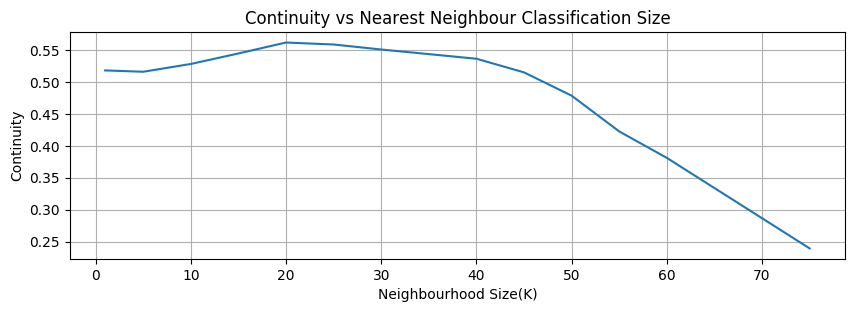

In [198]:
dd_orig = distance_matrix(Y)
dd_proj = distance_matrix(X)
nn_orig = dd_orig.argsort()
nn_proj = dd_proj.argsort()
ranks_proj = rank_matrix(dd_proj)
ks=[1,5,10,15,20,25,30,40,45,50,55,60,75]
j=0
cont=[]
for k in ks:
    moved = []
    for i in range(Y.shape[0]):
        moved.append(moved_out(nn_orig, nn_proj, i, k))
    cont.append(trustcont_sum(moved, ranks_proj, k))
    print('Neearest neighbourboost size k =' + str(k)+ ' ' + 'Continuity:' + str(cont[j]))
    j+=1
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(ks,cont)
pyplot.xlabel('Neighbourhood Size(K)')
pyplot.ylabel('Continuity')
pyplot.grid()
pyplot.title('Continuity vs Nearest Neighbour Classification Size')

Neearest neighbourboost size k =1 Trust:0.7388775510204082
Neearest neighbourboost size k =5 Trust:0.5951304347826087
Neearest neighbourboost size k =10 Trust:0.5219644970414201
Neearest neighbourboost size k =15 Trust:0.5613852813852814
Neearest neighbourboost size k =20 Trust:0.5681726618705036
Neearest neighbourboost size k =25 Trust:0.6066322580645161
Neearest neighbourboost size k =30 Trust:0.5686605504587157
Neearest neighbourboost size k =40 Trust:0.5240506329113923
Neearest neighbourboost size k =45 Trust:0.5103958333333334
Neearest neighbourboost size k =50 Trust:0.47578775510204085
Neearest neighbourboost size k =55 Trust:0.4244444444444444
Neearest neighbourboost size k =60 Trust:0.39603846153846156
Neearest neighbourboost size k =75 Trust:0.4240999999999999


Text(0.5,1,'Trust vs Nearest Neighbour Classification Size')

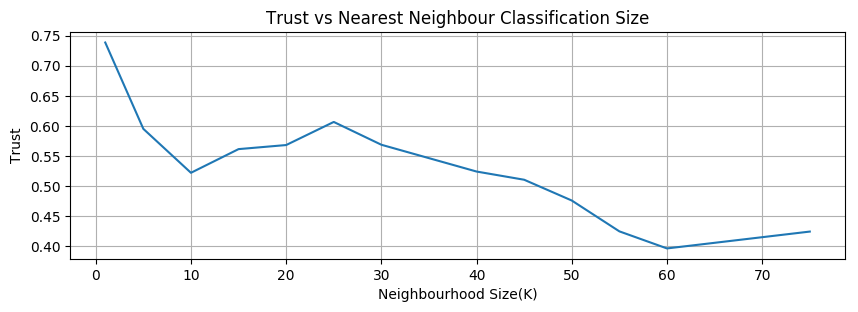

In [199]:
ranks_orig =rank_matrix(dd_orig)
trust = []
j=0
for k in ks:
    moved = []
    for i in range(Y.shape[0]):
        moved.append(moved_in(nn_orig, nn_proj, i, k))
    trust.append(trustcont_sum(moved, ranks_orig, k))
    print('Neearest neighbourboost size k =' + str(k)+ ' ' + 'Trust:' + str(trust[j]))
    j+=1
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(ks,trust)
pyplot.grid()
pyplot.xlabel('Neighbourhood Size(K)')
pyplot.ylabel('Trust')
pyplot.title('Trust vs Nearest Neighbour Classification Size')

## Bayesian GPLVM

In [201]:
kernel = GPy.kern.RBF(5, ARD=True)
m = GPy.models.BayesianGPLVM(Y, 5,  init="PCA",kernel=kernel,num_inducing=20,stochastic=True)
m.data_labels = Y.argmax(axis=1)
loss2 = m.optimize('lbfgs', messages=1,max_iters=10000) #scg', 'lbfgs', 'tnc'
##m.optimize?

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i       f              |g|        
    00s16  00005   1.361515e+03   1.457690e+05 
    00s19  00006   1.920066e+05   4.532025e+10 
    03s23  00191  -9.522306e+01   3.764154e+02 
    04s25  00262  -1.102793e+02   1.718470e+02 
    07s26  00467  -1.272224e+02   2.913073e+01 
    21s38  01450  -1.511796e+02   4.218914e+00 
    31s46  02143  -1.530284e+02   1.247889e-01 
    42s52  02912  -1.545756e+02   1.840860e-02 
    45s53  03120  -1.545799e+02   2.651955e-03 
    47s25  03241  -1.545803e+02   1.100536e-03 
Runtime:     47s25
Optimization status: Converged



 /home/aneeqr/.local/lib/python3.6/site-packages/matplotlib/__init__.py:1867: MatplotlibDeprecationWarning:The *left* kwarg to `bar` is deprecated use *x* instead. Support for *left* will be removed in Matplotlib 3.0


 /home/aneeqr/.local/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


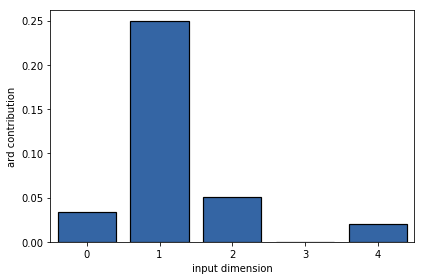

In [202]:
m.kern.plot_ARD()

In [203]:
Kfu2 =  m.kern.K(m.X.mean, m.Z)
Kuu2 = m.kern.K(m.Z, m.Z)
Kuf2 = Kfu2.T 
print('Kfu shape'+str(Kfu2.shape))
print('Kuu shape'+str(Kuu2.shape))
print('Kuf shape'+str(Kuf2.shape))

Kfu shape(100, 20)
Kuu shape(20, 20)
Kuf shape(20, 100)


In [204]:
Kff = np.dot(np.dot(Kfu2,pdinv(Kuu2)[0]),Kuf2)
Kff = Kff + np.eye(m.X.mean.shape[0])*(1/m.Gaussian_noise.variance)

In [205]:
Samples=1000
VS = [] # Vector Containing Matrix Samples (Xs)
for i in range(Samples):
    VS.append(pyro.sample('Variational Distibtuion',dist.MultivariateNormal(gplvm.get_param("X_loc"), scale_tril=gplvm.get_param("X_scale_tril")).independent(gplvm.get_param("X_loc").dim()-1),))

In [206]:
def Joint_Prob(Y,Xs,N,D,Q,m,K_new):
    K_inv = np.linalg.inv(K_new)
    #K_inv = pdinv(K_new)[0]
    Prob = -N*D*0.5*np.log(2*np.pi) - D/2*np.log(np.linalg.det(K_new))-1/2*np.trace(np.matmul(np.matmul(Y.T,K_inv),Y)) - (N*Q/2)*np.log(2*np.pi)-0.5*np.trace(np.matmul(Xs,Xs.T))
    return Prob 

In [207]:
N= Y.shape[0]
Q = 5
D=12
Join = []
for sample in VS:
    Join.append(Joint_Prob(Y,sample.detach().numpy(),N,D,Q,m,Kff))

In [208]:
def Var(X,gplvm,D,K_new):
    K_inv = pdinv(K_new)[0]
    temp = np.matmul(np.matmul(X.detach().numpy().T,K_inv),X.detach().numpy()) 
    qx = -0.5*(K.shape[0]*(D))*(np.log(np.pi*2)) - D/2*np.log(np.linalg.det(K_new)) - 0.5*np.trace(temp)
    return qx

In [209]:
qx = []
for sample in VS:
    qx.append(Var(sample,gplvm=gplvm,D=Q,K_new=K))

In [210]:
Rs,Rs2 = log_Ratios(qx,Join)

In [213]:
print('K:'+ str(psisloo(np.array(Rs2)))) 

K:(4422.821363921975, 4422.821363921975, -0.05952721332276403)


Text(0.5,1.05,'Bayesian GPLVM-DTC+SVI')

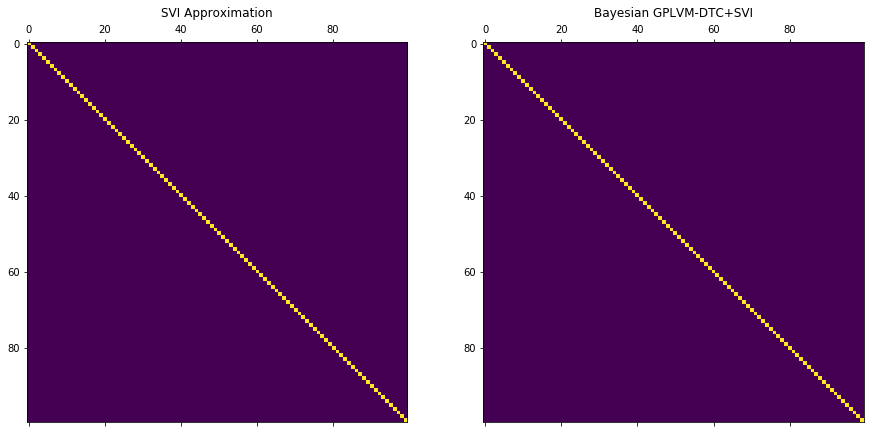

In [214]:
fig, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].matshow(K)
ax[0].set_title('SVI Approximation')
ax[1].matshow(Kff)
ax[1].set_title('Bayesian GPLVM-DTC+SVI')

Neearest neighbourboost size k =1 Continuity:0.9871428571428571
Neearest neighbourboost size k =5 Continuity:0.9787608695652174
Neearest neighbourboost size k =10 Continuity:0.9690414201183432
Neearest neighbourboost size k =15 Continuity:0.9615670995670995
Neearest neighbourboost size k =20 Continuity:0.9583381294964028
Neearest neighbourboost size k =25 Continuity:0.9563483870967742
Neearest neighbourboost size k =30 Continuity:0.9531804281345566
Neearest neighbourboost size k =40 Continuity:0.9552088607594936
Neearest neighbourboost size k =45 Continuity:0.9539861111111111
Neearest neighbourboost size k =50 Continuity:0.9483102040816327
Neearest neighbourboost size k =55 Continuity:0.9356565656565656
Neearest neighbourboost size k =60 Continuity:0.9179871794871794
Neearest neighbourboost size k =75 Continuity:0.8240333333333333


Text(0.5,1,'Continuity vs Nearest Neighbour Classification Size')

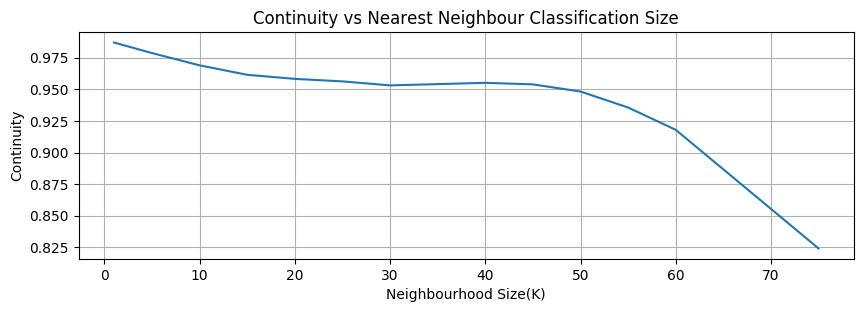

In [215]:
X0= list(m.X.mean[:,0])
X1= list(m.X.mean[:,1])
t= np.column_stack((X0, X1))
dd_proj = distance_matrix(t)
nn_orig = dd_orig.argsort()
nn_proj = dd_proj.argsort()
ranks_proj = rank_matrix(dd_proj)

ks=[1,5,10,15,20,25,30,40,45,50,55,60,75]
j=0
cont=[]
for k in ks:
    moved = []
    for i in range(Y.shape[0]):
        moved.append(moved_out(nn_orig, nn_proj, i, k))
    cont.append(trustcont_sum(moved, ranks_proj, k))
    print('Neearest neighbourboost size k =' + str(k)+ ' ' + 'Continuity:' + str(cont[j]))
    j+=1
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(ks,cont)
pyplot.grid()
pyplot.xlabel('Neighbourhood Size(K)')
pyplot.ylabel('Continuity')
pyplot.title('Continuity vs Nearest Neighbour Classification Size')

Neearest neighbourboost size k =1 Trust:0.9474489795918367
Neearest neighbourboost size k =5 Trust:0.9084782608695652
Neearest neighbourboost size k =10 Trust:0.9127100591715976
Neearest neighbourboost size k =15 Trust:0.9217489177489178
Neearest neighbourboost size k =20 Trust:0.916726618705036
Neearest neighbourboost size k =25 Trust:0.9071096774193549
Neearest neighbourboost size k =30 Trust:0.9016697247706422
Neearest neighbourboost size k =40 Trust:0.9118607594936708
Neearest neighbourboost size k =45 Trust:0.9155694444444444
Neearest neighbourboost size k =50 Trust:0.9118693877551021
Neearest neighbourboost size k =55 Trust:0.9006666666666666
Neearest neighbourboost size k =60 Trust:0.884423076923077
Neearest neighbourboost size k =75 Trust:0.731


Text(0.5,1,'Trust vs Nearest Neighbour Classification Size')

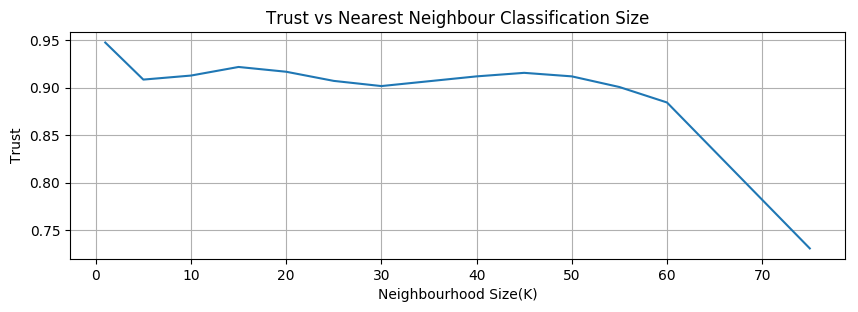

In [142]:
ranks_orig =rank_matrix(dd_orig)
trust = []
j=0
for k in ks:
    moved = []
    for i in range(Y.shape[0]):
        moved.append(moved_in(nn_orig, nn_proj, i, k))
    trust.append(trustcont_sum(moved, ranks_orig, k))
    print('Neearest neighbourboost size k =' + str(k)+ ' ' + 'Trust:' + str(trust[j]))
    j+=1
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(ks,trust)
pyplot.grid()
pyplot.xlabel('Neighbourhood Size(K)')
pyplot.ylabel('Trust')
#pyplot.yscale('log')
pyplot.title('Trust vs Nearest Neighbour Classification Size')

In [216]:
def psisloo(log_lik, **kwargs):
    r"""PSIS leave-one-out log predictive densities.

    Computes the log predictive densities given posterior samples of the log
    likelihood terms :math:`p(y_i|\theta^s)` in input parameter `log_lik`.
    Returns a sum of the leave-one-out log predictive densities `loo`,
    individual leave-one-out log predictive density terms `loos` and an estimate
    of Pareto tail indeces `ks`. The estimates are unreliable if tail index
    ``k > 0.7`` (see more in the references listed in the module docstring).

    Additional keyword arguments are passed to the :meth:`psislw()` function
    (see the corresponding documentation).

    Parameters
    ----------
    log_lik : ndarray
        Array of size n x m containing n posterior samples of the log likelihood
        terms :math:`p(y_i|\theta^s)`.

    Returns
    -------
    loo : scalar
        sum of the leave-one-out log predictive densities

    loos : ndarray
        individual leave-one-out log predictive density terms

    ks : ndarray
        estimated Pareto tail indeces

    """
    # ensure overwrite flag in passed arguments
    kwargs['overwrite_lw'] = True
    # log raw weights from log_lik
    lw = -log_lik
    # compute Pareto smoothed log weights given raw log weights
    lw, ks = psislw(lw, **kwargs)
    # compute
    lw += log_lik
    loos = sumlogs(lw, axis=0)
    loo = loos.sum()
    #print('Ks'+str(ks))
    return loo, loos, ks

def psislw(lw, Reff=1.0, overwrite_lw=False):
    """Pareto smoothed importance sampling (PSIS).

    Parameters
    ----------
    lw : ndarray
        Array of size n x m containing m sets of n log weights. It is also
        possible to provide one dimensional array of length n.

    Reff : scalar, optional
        relative MCMC efficiency ``N_eff / N``

    overwrite_lw : bool, optional
        If True, the input array `lw` is smoothed in-place, assuming the array
        is F-contiguous. By default, a new array is allocated.

    Returns
    -------
    lw_out : ndarray
        smoothed log weights
    kss : ndarray
        Pareto tail indices

    """
    if lw.ndim == 2:
        n, m = lw.shape
    elif lw.ndim == 1:
        n = len(lw)
        m = 1
    else:
        raise ValueError("Argument `lw` must be 1 or 2 dimensional.")
    if n <= 1:
        raise ValueError("More than one log-weight needed.")

    if overwrite_lw and lw.flags.f_contiguous:
        # in-place operation
        lw_out = lw
    else:
        # allocate new array for output
        lw_out = np.copy(lw, order='F')

    # allocate output array for kss
    kss = np.empty(m)
    #print(kss)

    # precalculate constants
    cutoff_ind = - int(np.ceil(min(0.2 * n, 3 * np.sqrt(n / Reff)))) - 1
    cutoffmin = np.log(np.finfo(float).tiny)
    logn = np.log(n)
    k_min = 1/3

    # loop over sets of log weights
    for i, x in enumerate(lw_out.T if lw_out.ndim == 2 else lw_out[None, :]):
        # improve numerical accuracy
        x -= np.max(x)
        # sort the array
        x_sort_ind = np.argsort(x)
        # divide log weights into body and right tail
        xcutoff = max(
            x[x_sort_ind[cutoff_ind]],
            cutoffmin
        )
        expxcutoff = np.exp(xcutoff)
        tailinds, = np.where(x > xcutoff)
        x2 = x[tailinds]
        n2 = len(x2)
        if n2 <= 4:
            # not enough tail samples for gpdfitnew
            k = np.inf
        else:
            # order of tail samples
            x2si = np.argsort(x2)
            # fit generalized Pareto distribution to the right tail samples
            np.exp(x2, out=x2)
            x2 -= expxcutoff
            k, sigma = gpdfitnew(x2, sort=x2si)
        if k >= k_min and not np.isinf(k):
            # no smoothing if short tail or GPD fit failed
            # compute ordered statistic for the fit
            sti = np.arange(0.5, n2)
            sti /= n2
            qq = gpinv(sti, k, sigma)
            qq += expxcutoff
            np.log(qq, out=qq)
            # place the smoothed tail into the output array
            x[tailinds[x2si]] = qq
            # truncate smoothed values to the largest raw weight 0
            x[x > 0] = 0
        # renormalize weights
        x -= sumlogs(x)
        # store tail index k
        kss[i] = k
        #print(k)

    # If the provided input array is one dimensional, return kss as scalar.
    if lw_out.ndim == 1:
        kss = kss[0]

    return lw_out, kss

def sumlogs(x, axis=None, out=None):
    """Sum of vector where numbers are represented by their logarithms.

    Calculates ``np.log(np.sum(np.exp(x), axis=axis))`` in such a fashion that
    it works even when elements have large magnitude.

    """
    maxx = x.max(axis=axis, keepdims=True)
    xnorm = x - maxx
    np.exp(xnorm, out=xnorm)
    out = np.sum(xnorm, axis=axis, out=out)
    if isinstance(out, np.ndarray):
        np.log(out, out=out)
    else:
        out = np.log(out)
    out += np.squeeze(maxx)
    return out
def gpdfitnew(x, sort=True, sort_in_place=False, return_quadrature=False):
    """Estimate the paramaters for the Generalized Pareto Distribution (GPD)

    Returns empirical Bayes estimate for the parameters of the two-parameter
    generalized Parato distribution given the data.

    Parameters
    ----------
    x : ndarray
        One dimensional data array

    sort : bool or ndarray, optional
        If known in advance, one can provide an array of indices that would
        sort the input array `x`. If the input array is already sorted, provide
        False. If True (default behaviour), the array is sorted internally.

    sort_in_place : bool, optional
        If `sort` is True and `sort_in_place` is True, the array is sorted
        in-place (False by default).

    return_quadrature : bool, optional
        If True, quadrature points and weight `ks` and `w` of the marginal posterior distribution of k are also calculated and returned. False by
        default.

    Returns
    -------
    k, sigma : float
        estimated parameter values

    ks, w : ndarray
        Quadrature points and weights of the marginal posterior distribution
        of `k`. Returned only if `return_quadrature` is True.

    Notes
    -----
    This function returns a negative of Zhang and Stephens's k, because it is
    more common parameterisation.

    """
    if x.ndim != 1 or len(x) <= 1:
        raise ValueError("Invalid input array.")

    # check if x should be sorted
    if sort is True:
        if sort_in_place:
            x.sort()
            xsorted = True
        else:
            sort = np.argsort(x)
            xsorted = False
    elif sort is False:
        xsorted = True
    else:
        xsorted = False

    n = len(x)
    PRIOR = 3
    m = 30 + int(np.sqrt(n))

    bs = np.arange(1, m + 1, dtype=float)
    bs -= 0.5
    np.divide(m, bs, out=bs)
    np.sqrt(bs, out=bs)
    np.subtract(1, bs, out=bs)
    if xsorted:
        bs /= PRIOR * x[int(n/4 + 0.5) - 1]
        bs += 1 / x[-1]
    else:
        bs /= PRIOR * x[sort[int(n/4 + 0.5) - 1]]
        bs += 1 / x[sort[-1]]

    ks = np.negative(bs)
    temp = ks[:,None] * x
    np.log1p(temp, out=temp)
    np.mean(temp, axis=1, out=ks)

    L = bs / ks
    np.negative(L, out=L)
    np.log(L, out=L)
    L -= ks
    L -= 1
    L *= n

    temp = L - L[:,None]
    np.exp(temp, out=temp)
    w = np.sum(temp, axis=1)
    np.divide(1, w, out=w)

    # remove negligible weights
    dii = w >= 10 * np.finfo(float).eps
    if not np.all(dii):
        w = w[dii]
        bs = bs[dii]
    # normalise w
    w /= w.sum()

    # posterior mean for b
    b = np.sum(bs * w)
    # Estimate for k, note that we return a negative of Zhang and
    # Stephens's k, because it is more common parameterisation.
    temp = (-b) * x
    np.log1p(temp, out=temp)
    k = np.mean(temp)
    if return_quadrature:
        np.negative(x, out=temp)
        temp = bs[:, None] * temp
        np.log1p(temp, out=temp)
        ks = np.mean(temp, axis=1)
    # estimate for sigma
    sigma = -k / b * n / (n - 0)
    # weakly informative prior for k
    a = 10
    k = k * n / (n+a) + a * 0.5 / (n+a)
    if return_quadrature:
        ks *= n / (n+a)
        ks += a * 0.5 / (n+a)

    if return_quadrature:
        #print('K:'+str(k))
        return k, sigma, ks, w
    else:
        #print('K:'+str(k))
        return k, sigma

def gpinv(p, k, sigma):
    """Inverse Generalised Pareto distribution function."""
    x = np.empty(p.shape)
    x.fill(np.nan)
    if sigma <= 0:
        return x
    ok = (p > 0) & (p < 1)
    if np.all(ok):
        if np.abs(k) < np.finfo(float).eps:
            np.negative(p, out=x)
            np.log1p(x, out=x)
            np.negative(x, out=x)
        else:
            np.negative(p, out=x)
            np.log1p(x, out=x)
            x *= -k
            np.expm1(x, out=x)
            x /= k
        x *= sigma
    else:
        if np.abs(k) < np.finfo(float).eps:
            # x[ok] = - np.log1p(-p[ok])
            temp = p[ok]
            np.negative(temp, out=temp)
            np.log1p(temp, out=temp)
            np.negative(temp, out=temp)
            x[ok] = temp
        else:
            # x[ok] = np.expm1(-k * np.log1p(-p[ok])) / k
            temp = p[ok]
            np.negative(temp, out=temp)
            np.log1p(temp, out=temp)
            temp *= -k
            np.expm1(temp, out=temp)
            temp /= k
            x[ok] = temp
        x *= sigma
        x[p == 0] = 0
        if k >= 0:
            x[p == 1] = np.inf
        else:
            x[p == 1] = -sigma / k
    return x

In [147]:
def log_Ratios(qx,Join):
    Rs = [] # Rations with exp
    Rs2 = [] # Rations without exp just log ratios
    for i in range(len(qx)):
        Rs.append(np.exp(Join[i]-qx[i]))
        Rs2.append(-1*(Join[i]-qx[i]))
    return Rs,Rs2

In [38]:
def d_euclidean(a,b):
    """Returns euclidean distance between vectors a and b"""

    return math.sqrt(sum([ (x - y)**2 for (x,y) in zip (a,b) ]))
def rank_matrix(x):
    """Returns rank matrix from pairwise distance matrix a"""
    
    m = x.argsort()
    r = numpy.zeros(x.shape)

    vectors = x.shape[0]

    for i in range(vectors):
        for j in range(vectors):
            pos = numpy.where(m[i,:]==j)
            r[i,j] = pos[0][0] # there should be a better syntax for this
        
    return r.astype('int')


def centering(x):
    """Center matrix x to origo"""
    return x - x.mean(axis=0)


def double_centering(x):
    """Double center matrix x"""
    pass

def distance_matrix(x, distf=None):
    """Returns distance matrix of pairwise distances between vectors
    stored in array a

    distf is function used to calculate distance between vectors,
    if None, euclidean distance is used
    """

    if distf == None:
        distf = d_euclidean

    vectors = x.shape[0]
    d = numpy.zeros([vectors, vectors])

    for i in range(vectors):
        for j in range(i,vectors):
            dd = distf(x[i,:], x[j,:])
            d[i,j] = dd
            d[j,i] = dd

    return d
def moved_out(nn_orig, nn_proj, i, k):
    """Determine points that were neighbours in the original space,
    but are not neighbours in the projection space.

    nn_orig
      neighbourhood matrix for original data

    nn_proj
      neighbourhood matrix for projection data

    i
      index of the point considered

    k
      size of the neighbourhood considered

    Return a list of indices for 'moved out' values 
    """

    oo = list(nn_orig[i, 1:k+1])
    pp = list(nn_proj[i, 1:k+1])

    for j in pp:
        if (j in pp) and (j in oo):
            oo.remove(j)

    return oo
def moved_in(nn_orig, nn_proj, i, k):
    """Determine points that are neighbours in the projection space,
    but were not neighbours in the original space.

    nn_orig
      neighbourhood matrix for original data

    nn_proj
      neighbourhood matrix for projection data

    i
      index of the point considered

    k
      size of the neighbourhood considered

    Return a list of indices for points which are 'moved in' to point i
    """

    pp = list(nn_proj[i, 1:k+1])
    oo = list(nn_orig[i, 1:k+1])

    for j in oo:
        if (j in oo) and (j in pp):
            pp.remove(j)

    return pp


def scaling_term(k, n):
    """Term that scales measure between zero and one

    k  size of the neighbourhood
    n  number of datapoints
    """

    if k < (n / 2.0):
        return 2.0 / ((n*k)*(2*n - 3*k - 1))
    else:
        return 2.0 / (n * (n - k) * (n - k - 1))


def trustcont_sum(moved, ranks, k):
    """Calculate sum used in trustworthiness or continuity calculation.

    moved

       List of lists of indices for those datapoints that have either
       moved away in (Continuity) or moved in (Trustworthiness)
       projection

    ranks

       Rank matrix of data set. For trustworthiness, ranking is in the
       original space, for continuity, ranking is in the projected
       space.

    k
       size of the neighbournood
    """

    n = ranks.shape[0]
    s = 0

    # todo: weavefy this for speed
    for i in range(n):
        for j in moved[i]:
            s = s + (ranks[i, j] - k)

    a = scaling_term(k, n)

    return 1 - a * s